####  Setup

In [1]:
import pandas as pd
import os
import math
import json
import matplotlib.pyplot as plt 
corpus_dir = 'corpus/'

/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [102]:
corpus_files = os.listdir(corpus_dir) 
corpus_files = [file for file in corpus_files if file.endswith(".csv")]

### Valid Responses Data

Contabilizamos para cada ejecución la cantidad de respuestas válidas por bloque.

Respuestas válidas != Respuestas correctas. Válidas para el tono: ["A", "S"] y para el número: ["J", "K"].

In [2]:
# date, gender, hand, age, response_amount_block_1, response_amount_block_2, response_amount_block_3, response_amount_block_4, total_response_amount
# read files
df = pd.DataFrame(columns=["date", "gender", "hand", "age", "response_amount_block_1", "response_amount_block_2", "response_amount_block_3", "response_amount_block_4", "total_response_amount"])
for file in corpus_files:
    file_df = pd.read_csv(f"{corpus_dir}/{file}")
    file = file.split(".")[-2]
    date, gender, hand, age = file.split("_")[1:]
    gender = "woman" if gender == "Mujer" else "man"
    hand = "right" if hand == "Derecha" else "left"
    count_block = lambda block_number : sum(file_df['block'] == block_number)
    b1, b2, b3, b4 = count_block(0), count_block(1), count_block(2), count_block(3)
    df.loc[len(df.index)] = [date, gender, hand, int(age), 
                                  b1, b2, 
                                  b3, b4, 
                                  len(file_df)]

df.to_csv("metadata.csv")

In [64]:
corpus_files = os.listdir(corpus_dir) 
d = 0
for file in corpus_files:
    file_df = pd.read_csv(f"{corpus_dir}/{file}")
    delays = set(file_df["delay"].values)
    d += len(delays)==4
print(d)

46


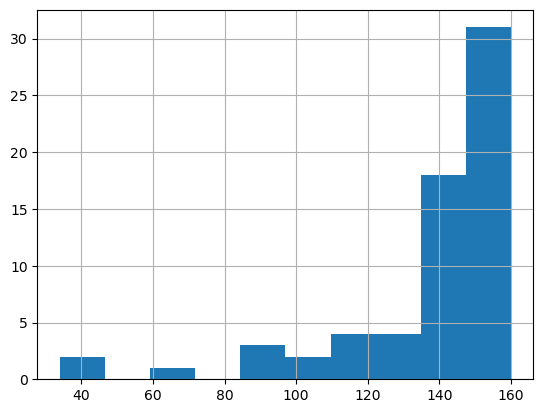

In [3]:
df["total_response_amount"].hist()

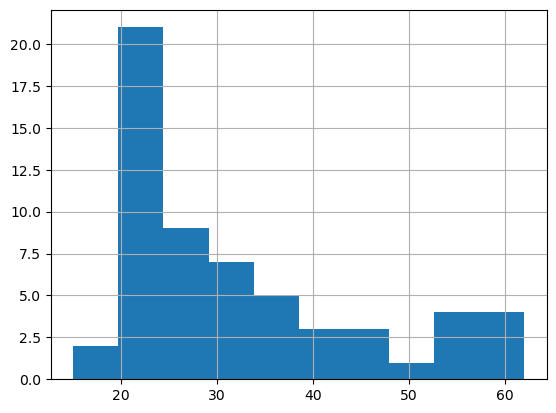

In [53]:
df["age"].hist()

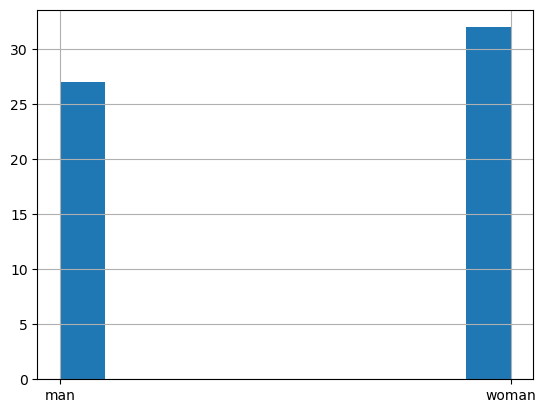

In [54]:
df["gender"].hist()

### Figuras del paper

## Figure 2 / Table 2. Effects of the Different Manipulations on the Mean and Dispersion of RT

A. Cambios en el promedio de RT de la tarea de números cuando el delay == 1025 para diferentes manipulaciones experimentales. Cambiar la notación hace al RT mas lento, y dentro de esa condición, las respuestas son mas lentas para distancias cortas que largas. La diferencia ente las condiciones de distancia cercana o lejana es independiente de la manipulación experimental.

B. A different pattern is observed for the interquartile range, which provides a measure of dispersion. While distance manipulation results in a
major change of the interquartile range, there is not a major effect of notation or response complexity.

In [142]:
# get DF (RT_digits_close, RT_digits_far, RT_words_close, RT_words_far) FOR ONLY delay == 1025
indexes = ["RT", "distance", "notation"]

mean_RT_delay_1025 = pd.DataFrame()
for file in corpus_files:
        file_df = pd.read_csv(f"{corpus_dir}/{file}")
        file_df = file_df[file_df["delay"] == 1025]
        file_df["notation"] = file_df.apply(lambda row: "word" if row.is_word else "digit", axis=1)
        file_df["distance"] = file_df.apply(lambda row: "close" if abs(45 - row.number) <= 12 else "far", axis=1)
        aver = file_df.groupby(["notation", "distance"]).rt_2.mean().to_frame()

        mean_RT_delay_1025 = pd.concat([
            mean_RT_delay_1025,
            pd.DataFrame(file_df.groupby(["notation", "distance"]).rt_2.mean())
            ], axis=0)
#mean_RT_delay_1025["file"] = corpus_files

In [148]:
mean_RT_delay_1025 = mean_RT_delay_1025.reset_index()

In [105]:
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm

In [153]:
mean_RT_delay_1025

,notation,distance,rt_2
0,digit,close,519.125000
1,digit,far,432.916667
2,word,close,796.250000
3,word,far,751.250000
4,digit,close,813.800000
...,...,...,...
199,word,far,877.000000
200,digit,close,639.900000
201,digit,far,613.400000
202,word,close,884.777778


In [158]:
formula = "rt_2 ~ C(notation) + C(distance)"
lm = ols(formula, mean_RT_delay_1025).fit()
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                   rt_2   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     28.66
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           1.12e-11
Time:                        12:58:19   Log-Likelihood:                -1332.3
No. Observations:                 204   AIC:                             2671.
Df Residuals:                     201   BIC:                             2681.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             659.3705    

In [156]:
print(lm.params)

Intercept              659.370500
C(notation)[T.word]    160.538469
C(distance)[T.far]     -75.242457
dtype: float64
